In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Optional: nicer plots
sns.set(style='whitegrid')


In [9]:
# Download the Online Retail dataset from UCI directly into Colab
!wget -O "Online Retail.xlsx" https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

# Load it into a DataFrame
import pandas as pd

df = pd.read_excel("Online Retail.xlsx", sheet_name=0, engine='openpyxl',
                   usecols=['InvoiceNo', 'StockCode', 'Description', 'Quantity',
                            'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'])

df.head()

# Drop missing CustomerIDs and remove credit/refunded transactions
df = df[df['CustomerID'].notnull()]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]  # remove canceled invoices
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

import datetime as dt

# Set reference date one day after last purchase
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by customer to compute RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview
rfm.head()

# Scale the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# KMeans Clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'})

cluster_summary


--2025-04-19 03:25:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx      [    <=>             ]  22.62M  30.0MB/s    in 0.8s    

2025-04-19 03:25:35 (30.0 MB/s) - ‘Online Retail.xlsx’ saved [23715344]



<ipython-input-9-d753b52aa89a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,15.672986,22.047393,12453.225924,211
1,248.564030,1.551789,478.107581,1062
2,7.384615,82.692308,127338.313846,13
3,43.910580,3.655748,1349.698298,3053


In [14]:
# Standardize RFM values for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(data[['Recency', 'Frequency', 'Monetary']])


In [15]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [16]:
# Summarize the characteristics of each cluster
cluster_summary = data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'})

cluster_summary


,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,220.485714,13.392857,367.233479,140
1,277.902256,7.586466,315.291143,133
2,171.112676,10.267606,897.385951,71
3,84.467949,8.506410,290.499199,156


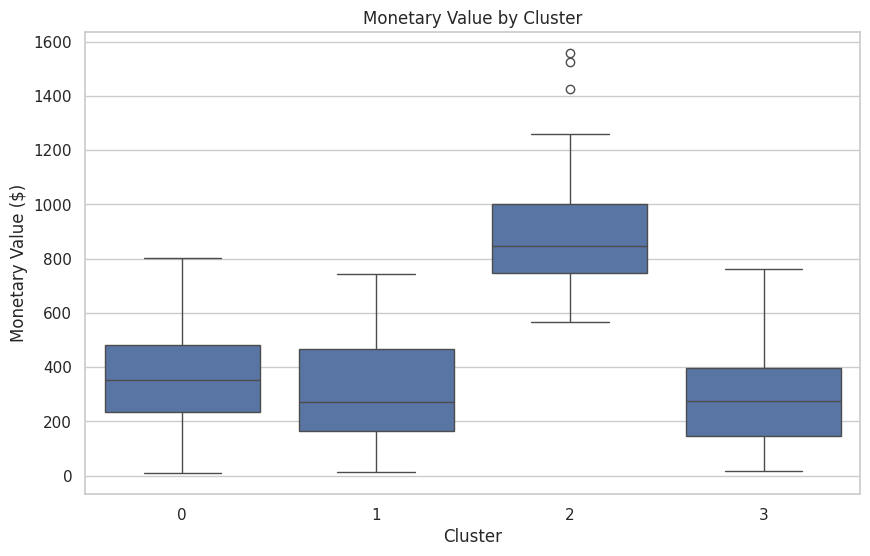

In [17]:
# Visualize Monetary by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Cluster', y='Monetary')
plt.title("Monetary Value by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Monetary Value ($)")
plt.show()


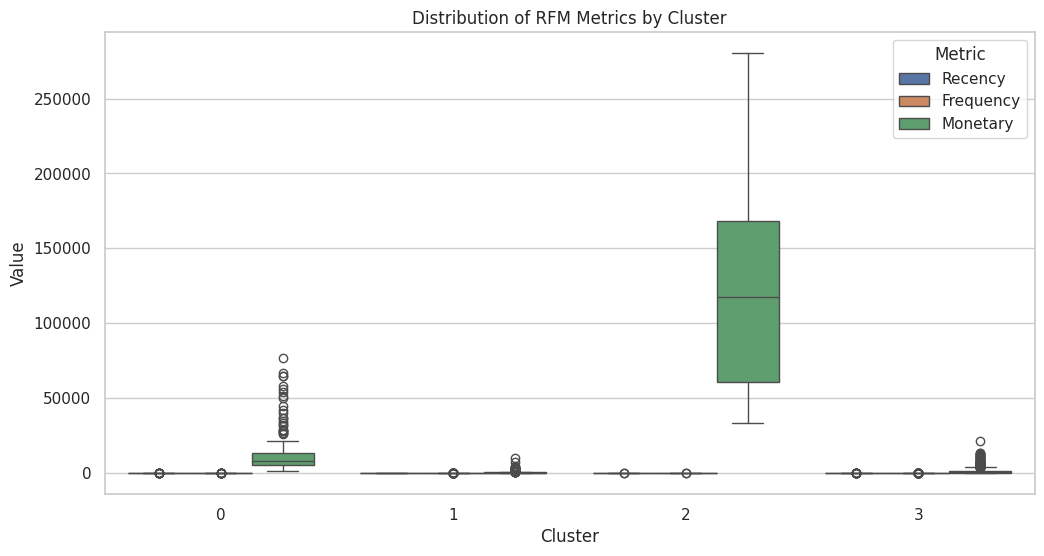

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the RFM table to long format for seaborn
rfm_melted = rfm.melt(id_vars='Cluster', value_vars=['Recency', 'Frequency', 'Monetary'],
                      var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=rfm_melted, x='Cluster', y='Value', hue='Metric')
plt.title("Distribution of RFM Metrics by Cluster")
plt.show()


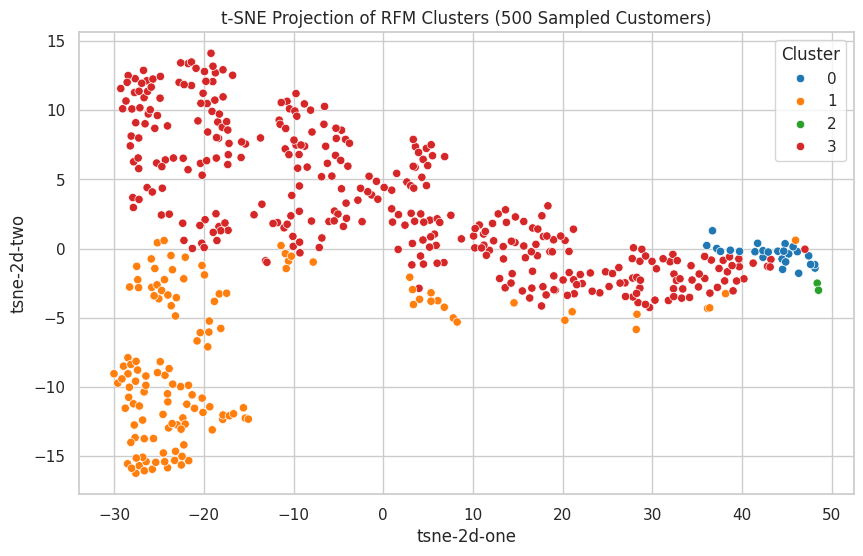

In [21]:
from sklearn.manifold import TSNE

# Sample 500 customers for visualization (random sample)
rfm_sampled = rfm.sample(n=500, random_state=42).reset_index(drop=True)

# Fit t-SNE on the scaled RFM values for sampled customers
rfm_scaled_sampled = scaler.transform(rfm_sampled[['Recency', 'Frequency', 'Monetary']])
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(rfm_scaled_sampled)

# Add results to sampled dataframe
rfm_sampled['tsne-2d-one'] = tsne_results[:,0]
rfm_sampled['tsne-2d-two'] = tsne_results[:,1]

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='Cluster',
    palette=sns.color_palette("tab10", n_colors=4),
    data=rfm_sampled,
    legend='full'
)
plt.title("t-SNE Projection of RFM Clusters (500 Sampled Customers)")
plt.show()


In [22]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'}).round(2)

cluster_summary


,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,15.67,22.05,12453.23,211
1,248.56,1.55,478.11,1062
2,7.38,82.69,127338.31,13
3,43.91,3.66,1349.70,3053
